## Modeling Tuning Notebook:

Application of GridSearchCV, regularization and parameter tuning on selected models


## Hyperparameter Tuning: 

Include GridSearch for each model. 

Tuning Logistic Regression...
Tuning AdaBoost...
Tuning Neural Network...


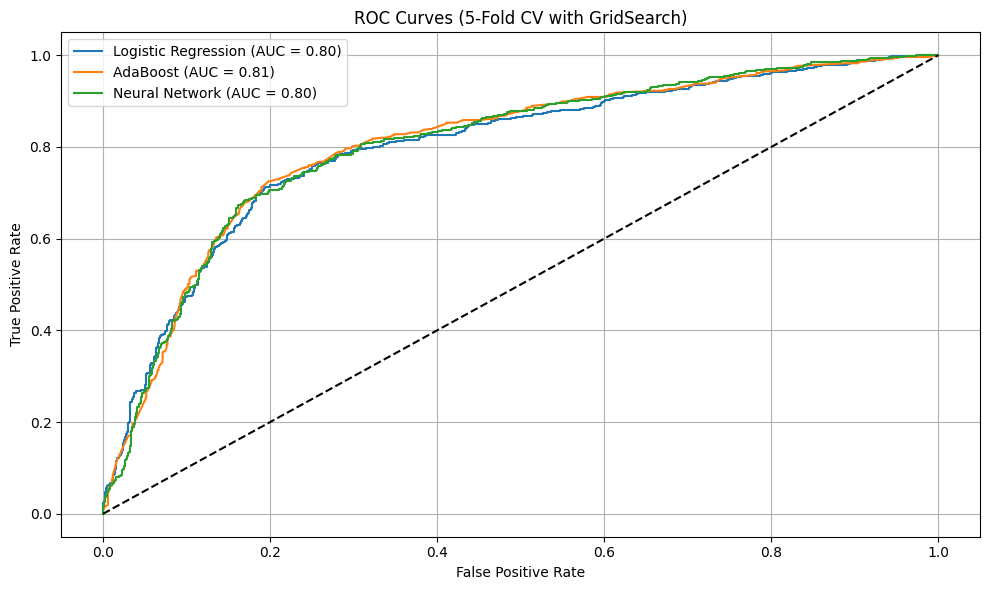

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Best Params
0,Logistic Regression,0.768,0.677,0.588,0.629,0.800,{'clf__C': 0.01}
1,AdaBoost,0.777,0.673,0.650,0.661,0.806,"{'clf__learning_rate': 0.5, 'clf__n_estimators..."
2,Neural Network,0.776,0.686,0.613,0.648,0.805,"{'clf__activation': 'relu', 'clf__alpha': 0.00..."


In [8]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib, os

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# Load preprocessed dataset and pipeline 
df = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

# Extract raw X and y 
X_raw = df.drop("is_recid", axis=1).copy()
y = df["is_recid"].copy()

#  Apply pipeline 
X_transformed = pipeline.transform(X_raw)

# Select only the 7 modeling features
selected_features = [
    "age", "sex", "juv_misd_count", "juv_fel_count",
    "priors_count", "c_charge_degree", "c_charge_desc"
]
feature_indices = [X_raw.columns.get_loc(f) for f in selected_features]
X_selected = X_transformed[:, feature_indices]

# Train/Val/Test Split: 70% to train, 30% evaluation (15% validation, 15% test)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_selected, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.176, stratify=y_trainval, random_state=42
)

# Apply 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
top_models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(n_estimators=100, random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ])
}

# Parameter grids for GridSearchCV
param_grids = {
    "Logistic Regression": {"clf__C": [0.001, 0.01, 0.1, 1, 10]}, #expanded range from {"clf__C": [0.01, 0.1, 1, 10]}
    "AdaBoost": {"clf__n_estimators": [50, 100, 150], "clf__learning_rate": [0.5, 1.0, 1.5]}, # extended parameters from only {"clf__n_estimators": [100]},
    "Neural Network": {"clf__alpha": [0.0001, 0.001, 0.01], "clf__hidden_layer_sizes": [(32,), (64,), (64, 32)], "clf__activation": ['relu', 'tanh']}, # extended parameters from only {"clf__alpha": [0.0001]}
}

# Placeholder for storing results
results = []
plt.figure(figsize=(10, 6))

for name in top_models:
    print(f"Tuning {name}...")
    grid = GridSearchCV(top_models[name], param_grids[name], cv=cv, scoring="roc_auc", n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_proba = best_model.predict_proba(X_val)[:, 1]
    y_pred = best_model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3),
        "Best Params": grid.best_params_
    })

# ROC Plot and Save Results 
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (5-Fold CV with GridSearch)")
plt.legend()
plt.grid(True)
plt.tight_layout()
os.makedirs("../reports/02_modeling/tuning", exist_ok=True)
plt.savefig("../reports/02_modeling/tuning/model_comparison_roc_cv_tuned.png")
plt.show()

# Save Results Table 
results_df = pd.DataFrame(results)
model_order = [
    "Logistic Regression", "AdaBoost", "Neural Network"
]
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/02_modeling/tuning/model_performance_comparison_cv_tuned_results.csv", index=False)
results_df

Compare tuned results with untuned results: 

In [9]:
# === Load baseline (untuned) and tuned results ===
baseline_path = "../reports/02_modeling/baseline/model_selection_metrics_summary.csv"
tuned_path = "../reports/02_modeling/tuning/model_performance_comparison_cv_tuned_results.csv"

df_baseline = pd.read_csv(baseline_path)
df_tuned = pd.read_csv(tuned_path)

# === Filter only validation results from baseline ===
df_val_baseline = df_baseline[df_baseline["Set"] == "Validation"].copy()

# === Merge on Model name ===
df_merged = df_val_baseline.merge(
    df_tuned,
    on="Model",
    suffixes=("_Baseline", "_Tuned")
)

# === Rearrange and round for readability ===
cols_order = [
    "Model",
    "Accuracy_Baseline", "Accuracy_Tuned",
    "Precision_Baseline", "Precision_Tuned",
    "Recall_Baseline", "Recall_Tuned",
    "F1 Score_Baseline", "F1 Score_Tuned",
    "AUC_Baseline", "AUC_Tuned"
]

df_merged = df_merged[cols_order]
df_merged = df_merged.sort_values(by="Model").reset_index(drop=True)

# === Export results to CSV ===
output_path = "../reports/02_modeling/tuning/tuned_vs_untuned_validation_comparison.csv"
df_merged.to_csv(output_path, index=False)

# === Display summary ===
df_merged


,Model,Accuracy_Baseline,Accuracy_Tuned,Precision_Baseline,Precision_Tuned,Recall_Baseline,Recall_Tuned,F1 Score_Baseline,F1 Score_Tuned,AUC_Baseline,AUC_Tuned
0,AdaBoost,0.777,0.777,0.675,0.673,0.644,0.650,0.659,0.661,0.804,0.806
1,Logistic Regression,0.767,0.768,0.671,0.677,0.600,0.588,0.633,0.629,0.800,0.800
2,Neural Network,0.775,0.776,0.680,0.686,0.621,0.613,0.649,0.648,0.801,0.805


Compare finetuned & regularized results with tuned and untuned results: 

In [16]:
# Load your files
baseline_df = pd.read_csv("../reports/02_modeling/baseline/model_selection_metrics_summary.csv")
tuned_df = pd.read_csv("../reports/02_modeling/tuning/model_performance_comparison_cv_tuned_results.csv")
finetuned_df = pd.read_csv("../reports/02_modeling/tuning/model_validation_comparison_log.csv")

# Keep only validation data from baseline
baseline_df = baseline_df[baseline_df["Set"] == "Validation"].drop(columns="Set")

# Get latest finetuned result per model
finetuned_df = finetuned_df.sort_values("Timestamp").groupby("Model").tail(1)

# Common metrics
metrics = ["F1 Score", "Precision", "Recall", "Accuracy", "AUC"]

# Label and align all DataFrames
baseline_df["Type"] = "Baseline"
tuned_df["Type"] = "Tuned"
finetuned_df["Type"] = "Finetuned"

tuned_df = tuned_df[["Model", *metrics, "Type"]]
finetuned_df = finetuned_df[["Model", *metrics, "Type"]]

finetuned_df

,Model,F1 Score,Precision,Recall,Accuracy,AUC,Type
6,Neural Network,0.680,0.664,0.696,0.780,0.802,Finetuned
7,AdaBoost,0.661,0.673,0.650,0.777,0.806,Finetuned
8,Logistic Regression,0.666,0.605,0.741,0.751,0.800,Finetuned


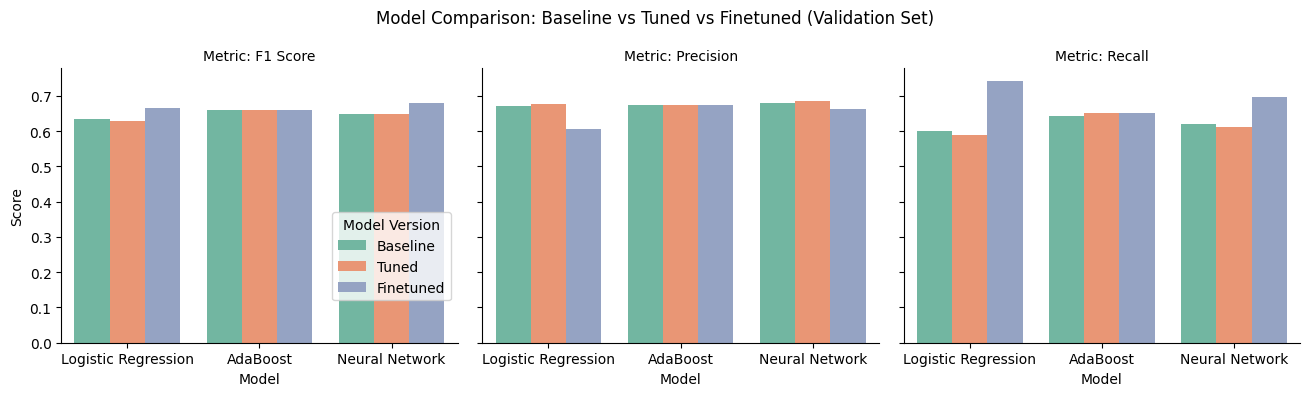

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your files
baseline_df = pd.read_csv("../reports/02_modeling/baseline/model_selection_metrics_summary.csv")
tuned_df = pd.read_csv("../reports/02_modeling/tuning/model_performance_comparison_cv_tuned_results.csv")
finetuned_df = pd.read_csv("../reports/02_modeling/tuning/model_validation_comparison_log.csv")

# Keep only validation data from baseline
baseline_df = baseline_df[baseline_df["Set"] == "Validation"].drop(columns="Set")

# Get latest finetuned result per model
finetuned_df = finetuned_df.sort_values("Timestamp").groupby("Model").tail(1)

# Common metrics
metrics = ["F1 Score", "Precision", "Recall"]

# Label and align all DataFrames
baseline_df["Type"] = "Baseline"
tuned_df["Type"] = "Tuned"
finetuned_df["Type"] = "Finetuned"

tuned_df = tuned_df[["Model", *metrics, "Type"]]
finetuned_df = finetuned_df[["Model", *metrics, "Type"]]

# Merge into single long-format DataFrame
combined = pd.concat([baseline_df, tuned_df, finetuned_df])
melted = combined.melt(id_vars=["Model", "Type"], value_vars=metrics, var_name="Metric", value_name="Score")

# Plot with improved layout
g = sns.catplot(
    data=melted, kind="bar",
    x="Model", y="Score", hue="Type", col="Metric",
    col_wrap=3, height=4, aspect=1.1,
    palette="Set2", legend_out=False
)

g.set_axis_labels("Model", "Score")
g.set_titles("Metric: {col_name}")
g.fig.subplots_adjust(top=0.9, right=0.85)
g.fig.suptitle("Model Comparison: Baseline vs Tuned vs Finetuned (Validation Set)")
g.add_legend(title="Model Version", bbox_to_anchor=(1.0, 0.5), loc="upper right")

plt.tight_layout()
plt.savefig("../reports/02_modeling/tuning/finetuned_results_comparison.png")
plt.show()



Illustrate tuning and regularization improvements: 

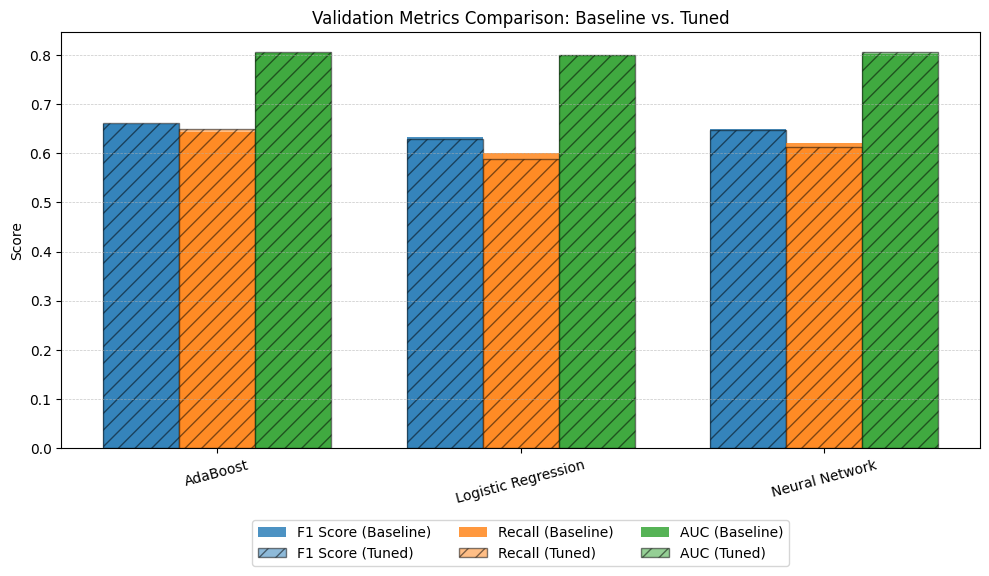

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load comparison results
df = pd.read_csv("../reports/02_modeling/tuning/tuned_vs_untuned_validation_comparison.csv")

# Setup
models = df["Model"]
metrics = ["F1 Score", "Recall", "AUC"]
x = np.arange(len(models))
bar_width = 0.25

positions = {
    "F1 Score": x - bar_width,
    "Recall": x,
    "AUC": x + bar_width
}

colors = {
    "F1 Score": "#1f77b4",
    "Recall": "#ff7f0e",
    "AUC": "#2ca02c"
}

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

for metric in metrics:
    # Baseline bars (solid)
    ax.bar(positions[metric], df[f"{metric}_Baseline"], width=bar_width, 
           label=f"{metric} (Baseline)", alpha=0.8, color=colors[metric])

    # Tuned bars (transparent + hatched)
    ax.bar(positions[metric], df[f"{metric}_Tuned"], width=bar_width, 
           label=f"{metric} (Tuned)", alpha=0.5, hatch='//', 
           color=colors[metric], edgecolor='black', linewidth=1.0)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylabel("Score")
ax.set_title("Validation Metrics Comparison: Baseline vs. Tuned")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig("../reports/02_modeling/tuning/all_metrics_baseline_vs_tuned_combined.png")
plt.show()
